# Probability and Statistics for Data Science

Fall 2022: Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

This is here so we can use `\P` and `\E` in LaTeX below.
$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}}$$

# Uncertainty: (how to) deal with it

When we're doing data science, we

- look at data
- make predictions about future values
- infer aspects of the underlying process

Fundamental to all stages are *randomness* and *uncertainty*.

*For instance:* randomized algorithms (e.g., stochastic gradient descent).

*For instance:*

Computing **a statistic**
gives you a number that describes a data set.

**Doing statistics** helps you understand
how reliable that description is
and how well it applies to the wider world.

We understand uncertainty, conceptually and quantitatively,
with **randomness**,

i.e., through *probability*.

## Goals of this class

- Become familiar with different types of probability models.

- Calculate properties of probability models.

- Construct and simulate from realistic models of data generation.

- Be able to test estimation and prediction methods with simulation.

- Gain familiarity with fundamental statistical concepts.

We'll spend a lot of time on *probability models*,
for applications from classical statistics
to machine learning.

Course mechanics: https://uodsci.github.io/dsci345

(break: fill out the survey)

# Getting random

**Today:** *Probability and expectation, conditional probabilities, and random variables.*

First:
let's get some [(pseudo-)randomness](https://numpy.org/doc/stable/reference/random/generator.html).

In [2]:
rng = np.random.default_rng()
help(rng.random)

Help on built-in function random:

random(...) method of numpy.random._generator.Generator instance
    random(size=None, dtype=np.float64, out=None)
    
    Return random floats in the half-open interval [0.0, 1.0).
    
    Results are from the "continuous uniform" distribution over the
    stated interval.  To sample :math:`Unif[a, b), b > a` multiply
    the output of `random` by `(b-a)` and add `a`::
    
      (b - a) * random() + a
    
    Parameters
    ----------
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    dtype : dtype, optional
        Desired dtype of the result, only `float64` and `float32` are supported.
        Byteorder must be native. The default value is np.float64.
    out : ndarray, optional
        Alternative output array in which to place the result. If size is not None,
        it

[0.78435098 0.66138201 0.08281614 0.0582125  0.6339182  0.0657847
 0.44473189 0.20037811 0.12838273 0.95713855]


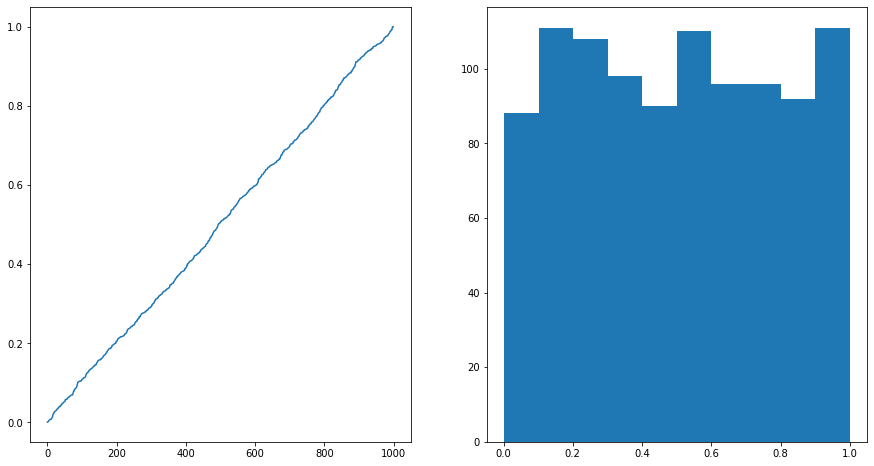

In [25]:
x = rng.random(size=1000)
print(x[:10])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.sort(x))
ax2.hist(x);

**Exercise:** put some other [distributions](https://numpy.org/doc/stable/reference/random/generator.html#distributions) into this code and see what happens.

# Example: false positives

Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?
(Here we really mean that “I” am a randomly chosen person from the US population.)

## Background data

The HIV rapid test has 99.4% specificity and 99.8% sensitivity.

Refreshing from [Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity),
specificity is the “true positive” rate and the sensitivity is the “true negative” rate:

- if you have HIV, the chance that it (wrongly) comes out negative is .006 = 0.6%;
- if you don’t have HIV, the chance that it (wrongly) comes out positive is .002 = .2%.

There are currently around
[1.2 million people with HIV in the US](https://www.hiv.gov/hiv-basics/overview/data-and-trends/statistics),
out of a total of [333 million](https://www.census.gov/popclock/),
giving an overall rate of 0.0036 = 0.36%.

In [4]:
true_pos = .994
true_neg = .998
pop_rate = 1.2 / 333

Answer 1: **simulation**

In [5]:
N = int(1e6)
hiv_status = pd.Series( rng.random(N) < pop_rate, name="HIV+")
n = np.sum(hiv_status)
test_result = pd.Series( np.full((N,), ""), name="test")
# hiv+ people
test_result[hiv_status] = ["+" if p < true_pos else "-" for p in rng.random(n)]
# hiv- people
test_result[~hiv_status] = ["-" if p < true_neg else "+" for p in rng.random(N - n)]

pd.crosstab(hiv_status, test_result, margins=True)

test,+,-,All
HIV+,,,
False,2000,994327,996327
True,3648,25,3673
All,5648,994352,1000000


What is the proportion of people who got a positive test result who actually have HIV?

In [6]:
pd.crosstab(hiv_status, test_result, margins=True)

test,+,-,All
HIV+,,,
False,2000,994327,996327
True,3648,25,3673
All,5648,994352,1000000


> Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?

In [7]:
hiv_given_plus = sum(hiv_status & (test_result == "+")) / np.sum(test_result == "+")
print(f"The proportion of the {np.sum(test_result == '+')} people "
      f"that had a positive test result that actually have HIV is {100*hiv_given_plus:.2f}%.")

The proportion of the 5648 people that had a positive test result that actually have HIV is 64.59%.


**Does this answer my question?**

*Next answer:* let's use math.

# Probability rules

(i.e., the *axioms of probability*)

## Probability rules

0. *Probabilities are proportions:* $\hspace{2em} 0 \le \P\{A\} \le 1$

1. *Everything:* $\hspace{2em} \P\{ \Omega \} = 1$

2. *Complements:* $\hspace{2em} \P\{ \text{not } A\} = 1 - \P\{A\}$

3. *Disjoint events:* If $\hspace{2em} \P\{A \text{ and } B\} = 0$
    then $\hspace{2em} \P\{A \text{ or } B\} = \P\{A\} + \P\{B\}$.

4. *Independence:* $A$ and $B$ are independent iff $\P\{A \text{ and } B\} = \P\{A\} \P\{B\}$.

5. *Conditional probability:* 
    $$\P\{A \;|\; B\} = \frac{\P\{A \text{ and } B\}}{ \P\{B\} }$$

## Bayes' rule

A consequence is that

$$\P\{B \;|\; A\} = \frac{\P\{B\} \P\{A \;|\; B\}}{ \P\{A\} } .$$

(*Example:* HIV test calculation, on the board.)

# Random variables

The mathematical definition of a "random variable" is
"a mapping from the probability space $\Omega$ into the real numbers".

We create random variables in programming all the time:

In [8]:
X = rng.random()

What's `X`? We don't know! But, we *do* know `X` is a *number*,
and so can do algebra with it, e.g., declare that `Y` is twice `X` squared plus one:

In [9]:
Y = 2 * X**2 + 1

Do you want to know what `X` is, for reals?
Too bad: for the analogy to hold up,
`X` should be the *abstract* instantiation of a draw from `rng.random()`.

## The distribution of a random variable

To say how $X$ behaves, we need to specify the *probability*
of each possible outcome. For instance:

- $X$ is the number rolled on a fair die: $\P\{X = k\} = 1/6$ for $k \in \{1, 2, 3, 4, 5, 6\}$.

- $X$ is uniformly chosen in $[0, 1)$: $\P\{X < x\} = x$ for $0 \le x \le 1$.

- $X$ is the number of times I get "heads" when flipping a fair coin before my first "tails": $\P\{X \ge k\} = 2^{-k}$.

For some of these, the set of possible values is *discrete*,
while for others it is *continuous*.

A *continuous distribution* has a *density function*,
i.e., a function $f_X(x)$ so that
$$  \P\{ a \le X \le b \} = \int_a^b f_X(x) dx . $$

*Example:* Let $X \sim \text{Normal}(0, 1)$. What is $\P\{ |X| > 2 \}$?

*Answer:*
By additivity of disjoint events, and then by complements,
$$
 \P\{ |X| > 2 \}
 =
  \P\{ X < - 2 \}
  + \P\{ X > 2 \} 
 =
 \P\{ -2 \le X \le 2 \} .
$$
[By Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution),
$X$ has density $e^{x^2/2}/\sqrt{2\pi}$, so this is
$$
    \int_{-2}^2 \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} dx .
$$

Oh, you want a *numerical* answer? Well, [scipy can tell us](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm):

In [42]:
from scipy.stats import norm
norm.cdf(2) - norm.cdf(-2)

0.9544997361036416

## Terminology:

- the *cumulative density function* of $X$ is
    $$ F_X(x) = \P\{ X < x \} . $$

- the *probability density function* of $X$, if it exists, is
    $$ f_X(x) = \frac{d}{dx} \P\{ X < x \} , $$
    or
    $$ \text{"} f_X(x) dx = \P\{ X = x \} dx \text{"} . $$

## Example:

Suppose we are surveying asteroid diameters,
which we find roughly follow an [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution)
with mean $40$ meters.
Out of 1,000 surveyed asteroids,
about how many have a diameter above 100 meters?
About how many have a diameter between 50 and 51 meters?